# 1. Import Libraries and Set Directory
---

Import Libraries

In [1]:
is_drive = 0

In [2]:
if is_drive==1 :
    from google.colab import drive
    drive.mount('/content/drive')

In [3]:
# directory management
import os
from glob import glob
# regular imports
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
# audio analysis
import librosa 
import librosa.display
import IPython.display as ipd
# imports for colors and plots
from itertools import cycle
sns.set_theme(style="white", palette=None)
color_pal = plt.rcParams["axes.prop_cycle"].by_key()["color"]
color_cycle = cycle(plt.rcParams["axes.prop_cycle"].by_key()["color"])
# imports for NN
import tensorflow as tf
from tensorflow import keras
import time

# 2. Draw Graphs of 1 File
---

a function that returns audio in numeric representation

Read all audio files and sort

In [4]:
if is_drive==1 :
  train_audio_dir = glob('/content/drive/MyDrive/audio-dataset/Train/*.wav')
else :
  train_audio_dir = glob('../Project/audio-dataset/Train/*.wav')

In [5]:
# Play audio file
ipd.Audio(train_audio_dir[0])

In [6]:
# check values and sample rate
y, sr = librosa.load(train_audio_dir[0])
print(f'Amplitude: {y[:10]}')
print(f'shape Amplitude: {y.shape}')
print(f'Sample Rate: {sr}')

Amplitude: [ 1.8123981e-05 -2.0144202e-04 -1.9833288e-04 -1.3722623e-04
 -2.8420327e-04 -2.4145069e-04 -1.5199321e-04 -3.4779514e-04
 -1.9760997e-04  2.3443635e-04]
shape Amplitude: (17640,)
Sample Rate: 22050


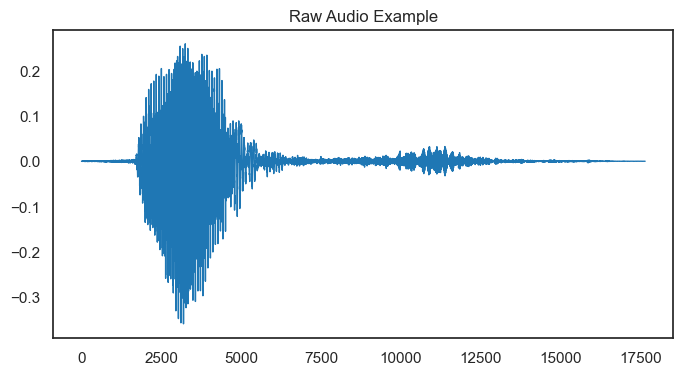

In [7]:
pd.Series(y).plot(figsize=(8, 4),
                  lw=1,
                  title='Raw Audio Example',
                 color=color_pal[0])
plt.show()

## Spectogram

In [8]:
# Short Time Fourier Transform
D = librosa.stft(y)
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
S_db.shape

(1025, 35)

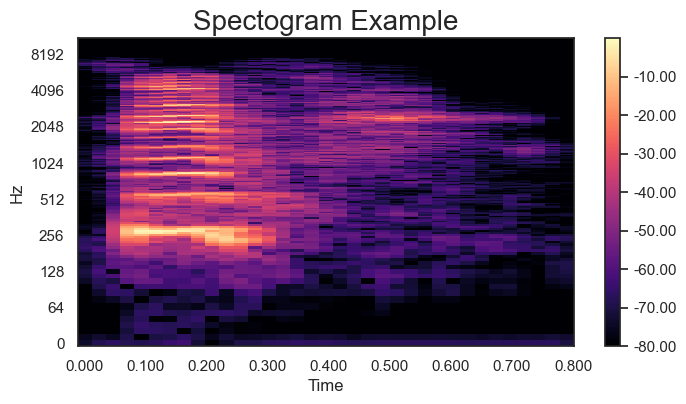

In [9]:
# Plot the transformed audio data
fig, ax = plt.subplots(figsize=(8,4))
img = librosa.display.specshow(S_db,
                              x_axis='time',
                              y_axis='log',
                              ax=ax)
ax.set_title('Spectogram Example', fontsize=20)
fig.colorbar(img, ax=ax, format=f'%0.2f')
plt.show()

## Mel Spectogram

In [10]:
S = librosa.feature.melspectrogram(y=y,
                                   sr=sr,
                                   n_mels=128,)
S_db_mel = librosa.amplitude_to_db(S, ref=np.max)

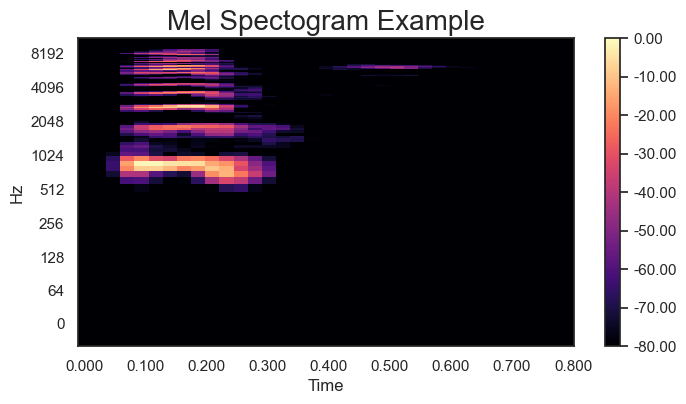

In [11]:
fig, ax = plt.subplots(figsize=(8, 4))
# Plot the mel spectogram
img = librosa.display.specshow(S_db_mel,
                              x_axis='time',
                              y_axis='log',
                              ax=ax)
ax.set_title('Mel Spectogram Example', fontsize=20)
fig.colorbar(img, ax=ax, format=f'%0.2f')
plt.show()

# 3. Load Dataset and Training the Models
---

## 3.1. Loading Spectograms

In [12]:
# Spectogram Path
if is_drive==1 :   
    TRAIN_DIR = "/content/drive/MyDrive/spectogram-dataset/Train/"
    TEST_DIR = "/content/drive/MyDrive/spectogram-dataset/Test/"
else :
    TRAIN_DIR = "../Project/spectogram-dataset/Train/"
    TEST_DIR = "../Project/spectogram-dataset/Test/"

In [13]:
def load_fsdd(train_spectrograms_path,test_spectrograms_path):
    x_train = []
    for root, _, file_names in os.walk(train_spectrograms_path):
        for file_name in file_names:
            file_path = os.path.join(root, file_name)
            spectrogram = np.load(file_path) # (n_bins, n_frames)
            x_train.append(spectrogram)
    x_train = np.array(x_train)        # -> (n_samples, n_bins, n_frames)
    x_train = x_train[..., np.newaxis] # -> (1200, 256, 22, 1)

    x_test  = []
    for root, _, file_names in os.walk(test_spectrograms_path):
        for file_name in file_names:
            file_path = os.path.join(root, file_name)
            spectrogram = np.load(file_path) # (n_bins, n_frames)
            x_test.append(spectrogram)
    x_test = np.array(x_test)        # -> (n_samples, n_bins, n_frames)
    x_test = x_test[..., np.newaxis] # -> (300, 256, 22, 1)

    return x_train,x_test

In [14]:
x_train, x_test = load_fsdd(TRAIN_DIR, TEST_DIR)

## 3.2 Simple Flatten AE

In [15]:
from keras import layers

In [16]:
BATCH_SIZE = 22
EPOCHS = 20
print(x_train.shape)
print(x_test.shape)
# flatten the dataset
x_train_sm = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test_sm  = x_test .reshape((len(x_test ), np.prod(x_test .shape[1:])))
print(x_train_sm.shape)
print(x_test_sm.shape)

(1200, 256, 22, 1)
(300, 256, 22, 1)
(1200, 5632)
(300, 5632)


In [17]:
# the size of compression dimension
encoding_dim = 256 # compression of factor 22 (5632/256), assuming the input is 5632
#input image
input_img = keras.Input(shape=(5632,))
#encoded representation of the input
encoded = layers.Dense(encoding_dim,activation='relu')(input_img)
# lossy reconstruction
decoded = layers.Dense(5632, activation="sigmoid")(encoded)

simple_ae = keras.Model(inputs=input_img, outputs=decoded)

simple_ae.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 5632)]            0         
                                                                 
 dense (Dense)               (None, 256)               1442048   
                                                                 
 dense_1 (Dense)             (None, 5632)              1447424   
                                                                 
Total params: 2,889,472
Trainable params: 2,889,472
Non-trainable params: 0
_________________________________________________________________


In [18]:
simple_ae_encoder = keras.Model(inputs=input_img, outputs=encoded)

In [19]:
encoded_input = keras.Input(shape=(encoding_dim,))
decoder_layer = simple_ae.layers[-1]
simple_ae_decoder = keras.Model(inputs=encoded_input, outputs=decoder_layer(encoded_input))

In [20]:
simple_ae.compile(optimizer='adam', loss='binary_crossentropy')

In [21]:
tic=time.time()
with tf.device('/GPU:1'):
    hist = simple_ae.fit( x_train_sm,x_train_sm,
                        epochs=EPOCHS,
                        batch_size=BATCH_SIZE,
                        shuffle=True,
                        validation_data=(x_test_sm,x_test_sm))
toc=time.time()
training_time=toc-tic

Epoch 1/20
55/55 [==============================] - 5s 63ms/step - loss: 0.4436 - val_loss: 0.4084
Epoch 2/20
55/55 [==============================] - 3s 58ms/step - loss: 0.3963 - val_loss: 0.3978
Epoch 3/20
55/55 [==============================] - 3s 55ms/step - loss: 0.3885 - val_loss: 0.3934
Epoch 4/20
55/55 [==============================] - 3s 54ms/step - loss: 0.3843 - val_loss: 0.3894
Epoch 5/20
55/55 [==============================] - 3s 57ms/step - loss: 0.3814 - val_loss: 0.3880
Epoch 6/20
55/55 [==============================] - 3s 54ms/step - loss: 0.3794 - val_loss: 0.3864
Epoch 7/20
55/55 [==============================] - 3s 57ms/step - loss: 0.3778 - val_loss: 0.3849
Epoch 8/20
55/55 [==============================] - 3s 56ms/step - loss: 0.3768 - val_loss: 0.3838
Epoch 9/20
55/55 [==============================] - 3s 58ms/step - loss: 0.3758 - val_loss: 0.3831
Epoch 10/20
55/55 [==============================] - 3s 58ms/step - loss: 0.3751 - val_loss: 0.3825
Epoch 11/

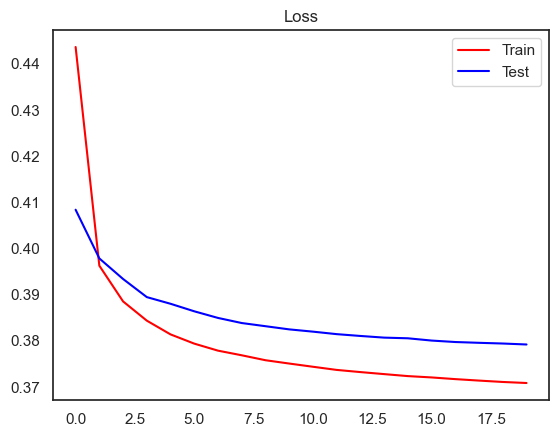

In [22]:
plt.title('Loss')
plt.plot(hist.history['loss'], 'r')
plt.plot(hist.history['val_loss'], 'b')
plt.legend(["Train", "Test"], loc=0, frameon=True)
plt.show()

In [23]:
#simple_ae.save("simple_ae.h5")
#print("saved")

## 3.3 Deep Convolutional AE

In [24]:
from autoencoder import Autoencoder

In [25]:
def pad(array, target_shape):
    return np.pad(
        array,
        [(0, target_shape[i] - array.shape[i]) for i in range(len(array.shape))],
        "constant",
    )

In [31]:
x_train_ae = pad(x_train, (1200, 256, 24, 1))
x_test_ae = pad(x_test, (300, 256, 24, 1))
LEARNING_RATE = 0.0005
BATCH_SIZE = 24
EPOCHS = 15
encoding_dim = 256 
print(x_train_ae.shape)
print(x_test_ae.shape)

(1200, 256, 24, 1)
(300, 256, 24, 1)


In [32]:
AE = Autoencoder(
    input_shape=(256, 24, 1),
    conv_filters=(32, 64, 64, 64),
    conv_kernels=(3, 3, 3, 3),
    conv_strides=(1, 2, 2, 1),
    latent_space_dim=encoding_dim
)

In [33]:
AE.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 256, 24, 1)]      0         
                                                                 
 encoder_conv_layer_1 (Conv2  (None, 256, 24, 32)      320       
 D)                                                              
                                                                 
 encoder_relu_1 (ReLU)       (None, 256, 24, 32)       0         
                                                                 
 encoder_bn_1 (BatchNormaliz  (None, 256, 24, 32)      128       
 ation)                                                          
                                                                 
 encoder_conv_layer_2 (Conv2  (None, 128, 12, 64)      18496     
 D)                                                              
                                                           

In [34]:
AE.compile(LEARNING_RATE)

In [35]:
tic=time.time()
with tf.device('/GPU:1'):
    hist = AE.train(x_train_ae, x_test_ae, BATCH_SIZE, EPOCHS)
toc=time.time()
training_time=toc-tic

Train on 1200 samples, validate on 300 samples
Epoch 1/15
1200/1200 [==============================] - 48s 40ms/sample - loss: 0.0472 - val_loss: 0.0618
Epoch 2/15
1200/1200 [==============================] - 42s 35ms/sample - loss: 0.0183 - val_loss: 0.0423
Epoch 3/15
1200/1200 [==============================] - 42s 35ms/sample - loss: 0.0133 - val_loss: 0.0454
Epoch 4/15
1200/1200 [==============================] - 42s 35ms/sample - loss: 0.0102 - val_loss: 0.0481
Epoch 5/15
1200/1200 [==============================] - 41s 35ms/sample - loss: 0.0086 - val_loss: 0.0414
Epoch 6/15
1200/1200 [==============================] - 42s 35ms/sample - loss: 0.0077 - val_loss: 0.0324
Epoch 7/15
1200/1200 [==============================] - 41s 34ms/sample - loss: 0.0072 - val_loss: 0.0229
Epoch 8/15
1200/1200 [==============================] - 43s 36ms/sample - loss: 0.0066 - val_loss: 0.0159
Epoch 9/15
1200/1200 [==============================] - 42s 35ms/sample - loss: 0.0065 - val_loss: 0.0133

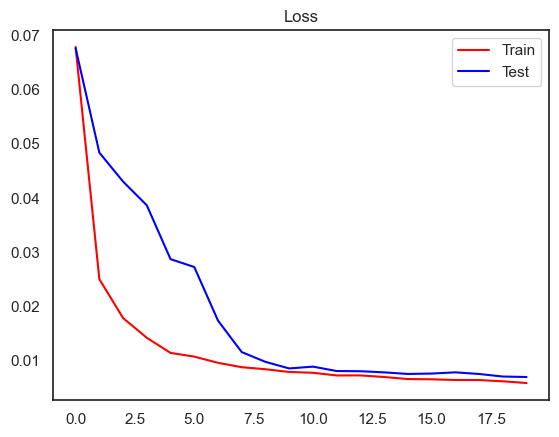

In [ ]:
plt.title('Loss')
plt.plot(hist.history['loss'], 'r')
plt.plot(hist.history['val_loss'], 'b')
plt.legend(["Train", "Test"], loc=0, frameon=True)
plt.show()

In [36]:
AE.save("AE-model")